In [1]:
clear
homedir = getenv('HOME');
workdir = getenv('WORK');
scradir = getenv('SCRATCH');
campdir = getenv('CAMP');
addpath(genpath([homedir '/work_MOM']));
addpath(genpath([homedir '/mytoolbox']));
addpath(genpath([homedir '/MyFuncs']));

In [2]:
t_al = [120]; dt_flxmean = 6/24;
nt = length(t_al);
it = 1;
[t1, t2] = deal(t_al(it), t_al(it)+dt_flxmean);
t15 = (t1 + t2)/2;
[yrstr, dystr, hrstr] = get_timestr(t1, 21); 
[yrstr15, dystr15, hrstr15] = get_timestr(t15, 21); 
    
dir_h = [campdir '/mom_ptemp/'];  
dir_l = [workdir '/MOM6_OUT/forc_uvh_64/']; tmStr = '_180d';
% dir_low = [workdir '/MOM6_exp/mom_lowRES/'];
dir_low = [workdir '/MOM6_OUT/forc_uvh_64/']; 
% 
[grid_h, ~, ~] = read_grid_MOM([dir_h '']); 
[grid_l, ~, ~] = read_grid_MOM([workdir '/MOM6_exp/mom_lowRES/']);

% ------- read fluxes
uvh_fnm_h = [dir_h 'sol_uvhm/uvh_mean__' yrstr15 '_' dystr15 '_' hrstr15 '.nc'];
uvh_fnm_l = [dir_l 'uvhm_CS_decomp' tmStr '/uvh_mean__' yrstr15 '_' dystr15 '_' hrstr15 '.nc'];
% uvh_fnm_low = [dir_low 'sol_uvhm/uvh_mean__' yrstr15 '_' dystr15 '_' hrstr15 '.nc'];
uvh_fnm_low = [dir_low 'uvhm_CS_decomp'  '/uvh_mean__' yrstr15 '_' dystr15 '_' hrstr15 '.nc'];

% 
uvh_h = ncstruct(uvh_fnm_h);
uvh_l = ncstruct(uvh_fnm_l);
uvh_low = ncstruct(uvh_fnm_low);

% ------- read lay thick
lay_fnm_h = [dir_h 'sol_h/h_snap__' yrstr '_' dystr '_' hrstr '.nc'];
lay_fnm_l = [dir_l 'sol_h/h_snap__' yrstr '_' dystr '_' hrstr '.nc'];
lay_fnm_low = [dir_low 'sol_h/h_snap__' yrstr '_' dystr '_' hrstr '.nc'];
% 
lay_h = ncstruct(lay_fnm_h);
lay_l = ncstruct(lay_fnm_l);
lay_low = ncstruct(lay_fnm_low);

In [3]:
% ----
flx_al = {uvh_h, uvh_low, uvh_l};
ds_h = {lay_h, lay_low, lay_l};
grid_al = {grid_h, grid_l, grid_l};
ncel = numel(flx_al);
ik = 1; 

% ----
fu_al = cell(1,ncel); fv_al = cell(1,ncel); spd_al = cell(1,ncel); uh_norm_al = cell(1,ncel);

for icel = 1:ncel
    fu = flx_al{icel}.uh(:,:,ik) ./ grid_al{icel}.dyCu;
    fv = flx_al{icel}.vh(:,:,ik) ./ grid_al{icel}.dxCv;
    % 
    fu(isnan(fu)) = 0; fv(isnan(fv)) = 0;
    [fup,fvp] = uv2p_CG(fu,fv);
    uh_norm = sqrt(fup.^2 + fvp.^2);
    %
    fup = fup ./ ds_h{icel}.h(:,:,ik); fvp = fvp ./ ds_h{icel}.h(:,:,ik);
    % speed
    spd = sqrt(fup.^2 + fvp.^2);
    
    fu_al{icel} = fup;
    fv_al{icel} = fvp;
    spd_al{icel} = spd;
    uh_norm_al{icel} = uh_norm;
end

% ------ dive
div_al = cell(1,ncel); 
for icel = 1:ncel
    g = grid_al{icel};
    fu = flx_al{icel}.uh(:,:,ik) ;
    fv = flx_al{icel}.vh(:,:,ik) ;
    div = calc_div_CG(fu,fv,ones(g.niu,g.nju),ones(g.niv,g.njv),g.dxT,g.dyT,1);
    div_al{icel} = div;
end

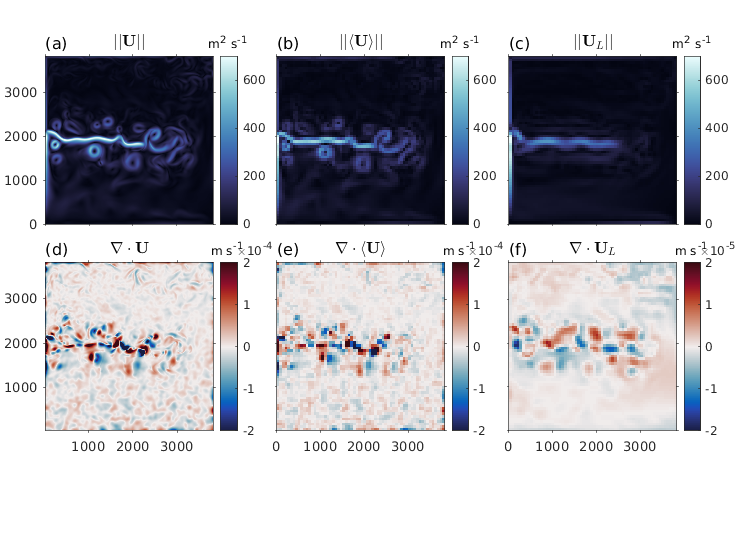

In [4]:
titls = {'$||\mathbf{U}||$', '$||\langle\mathbf{U}\rangle||$', '$||\mathbf{U}_L||$',...
        '$\nabla\cdot\mathbf{U}$', '$\nabla\cdot\langle\mathbf{U}\rangle$', '$\nabla\cdot \mathbf{U}_L$'};
% '$||\langle\overline{\mathbf{U}}\rangle||$',...
x_al = {grid_h.lonh, grid_l.lonh, grid_l.lonh, grid_l.lonh, grid_l.lonh, grid_l.lonh};
y_al = {grid_h.lath, grid_l.lath, grid_l.lath, grid_l.lath, grid_l.lath, grid_l.lath};
% plt_fields = [spd_al(:) div_al(:)];
% clim_al = {[0 1.5], [0 1.5], [-1 1]*2e-4, [-1 1]*2e-4};
plt_fields = [uh_norm_al(:) div_al(:)];
clim_al = {[0 7e2], [0 7e2], [0 7e2], [-1 1]*2e-4, [-1 1]*2e-4, [-1 1]*2e-5};
cmap_al = {'ice', 'ice', 'ice', 'balance', 'balance',  'balance'};

x_top = 0.06; y_top = 0.6; h_top = 0.3; w_top = h_top; dx_top = 0.01; dy = 0.07;
pos_top = { [x_top y_top w_top h_top], [x_top+w_top+dx_top y_top w_top h_top], [x_top+2*w_top+2*dx_top y_top w_top h_top],...
            [x_top y_top-h_top-dy w_top h_top], [x_top+w_top+dx_top y_top-h_top-dy w_top h_top], [x_top+2*w_top+2*dx_top y_top-h_top-dy w_top h_top]};

font = 'DejaVu Sans';
figure('DefaultTextFontName', font, 'DefaultAxesFontName', font);
% [ha, ~] = tight_subplot(2,3,[.05 .05],[.05 .05],[.10 .05]);

for icel = 1:6
    % axes(ha(icel));
    subplot('Position',pos_top{icel});
    [x, y] = deal(x_al{icel}, y_al{icel});
    f_do = plt_fields{icel};
    imagescn(x, y, f_do'); set(gca,'tickdir','out');
    axis square;
    if icel == 1
        set(gca,'xticklabel','');
    elseif icel == 2 || icel == 3
        set(gca,'xticklabel','','yticklabel','');
    elseif icel >= 5
        set(gca,'yticklabel','');
    end
    title(titls{icel},'fontsize',12,'Interpreter','latex');
    caxis(clim_al{icel});
    cmocean(cmap_al{icel})
   
    if icel <=3
        cb = colorbar;
        cb.Title.String = 'm^2 s^{-1}';
    end
    if icel >3
        cb = colorbar;
        cb.Title.String = 'm s^{-1}';
    end
end
hb = subplotlabel(gcf,'a','location','northwestoutside','offset',[0 0.02],'Prefix','(','Postfix',')','fontsize',12);

% --
set(gcf,'PaperPositionMode','auto'); 
fignm = [homedir '/work_MOM/figures/fig_appxD_massflux'];
% exportgraphics(gcf,[fignm '.pdf'], 'BackgroundColor','white','ContentType','vector')
